In [1]:
import ast
import numpy as np
import rdkit
from rdkit import Chem
from rdkit.Chem import BondType
import torch
import pandas as pd
import pickle

# 필요한 함수 정의

1. 동적 matrix(adjacency, feature) 생성 함수

In [2]:
def smiles_to_graph(smiles):
    molecule = Chem.MolFromSmiles(smiles)
    
    num_atoms = molecule.GetNumAtoms()
    
    adjacency = np.zeros((num_atoms, num_atoms), 'int64')
    features = np.zeros((num_atoms), 'int64')
    
    for atom in molecule.GetAtoms():
        i = atom.GetIdx()
        atom_type = atom_mapping[atom.GetSymbol()]
        features[i] = atom_type
        
        for neighbor in atom.GetNeighbors():
            j = neighbor.GetIdx()
            bond = molecule.GetBondBetweenAtoms(i, j)
            bond_type_idx = bond_mapping[bond.GetBondType().name]
            adjacency[[i, j], [j, i]] = bond_type_idx
            
    adjacency = torch.tensor(adjacency.tolist(), dtype=torch.int8)
    features = torch.tensor(features.tolist(), dtype=torch.int8)
    
    return adjacency, features

2. adjacency, features 정보로 분자 복구하는 함수

In [3]:
def graph_to_molecule(features, adjacency):
    molecule = Chem.RWMol()  # 편집 가능한 빈 molecule 추가
    num_atoms = len(features)
    atom_index_map = {}
    
    # 'features' 이용해서 molecule에 atom 추가
    for i in range(num_atoms):
        atom_type = features[i].item() # Convert tensor to int
        atom_symbol = atom_mapping[atom_type]
        new_atom_index = molecule.AddAtom(Chem.Atom(atom_symbol))
        atom_index_map[i] = new_atom_index

    # 'adjacency' 이용해서 molecule에 bond 추가
    for i in range(num_atoms):
        for j in range(i + 1, num_atoms):
            bond_type_idx = adjacency[i, j].item()  # Convert tensor to int

            if bond_type_idx == 0:
                continue

            bond_type = bond_mapping[bond_type_idx]

            new_i = atom_index_map[i]
            new_j = atom_index_map[j]

            if bond_type != 0:
                molecule.AddBond(new_i, new_j, bond_type)

    return molecule

3. df 받아서 list of dict 생성<br>

!!! 추출하고자 하는 속성명 df 내 컬럼명과 동일하게 바꾸기 !!!

In [4]:
def generate_pickle(df):
    mol_list = []
    for index, row in df.iterrows():
        smiles = row['smiles']
        bp = row['Y']     ### 꼭 맞춰서 바꾸기!!!!!!###

        adjacency, features = smiles_to_graph(smiles)

        molecule_dict = {
            'num_atom' : adjacency.shape[0],
            'atom_type' : torch.tensor(features, dtype=torch.int8),
            'bond_type' : torch.tensor(adjacency, dtype=torch.int8),
            'Y' : torch.tensor([bp], dtype=torch.float32) ### 꼭 맞춰서 바꾸기!!!!!!###
        }

        mol_list.append(molecule_dict)
        
    return mol_list

# Data load

In [5]:
data = pd.read_csv('./tox.csv')

data.columns

Index(['Unnamed: 0', 'smiles', 'Y'], dtype='object')

In [6]:
data.head(5)

,Unnamed: 0,smiles,Y
0,0,CCOc1ccc2nc(S(N)(=O)=O)sc2c1,0.0
1,1,CCN1C(=O)NC(c2ccccc2)C1=O,0.0
2,2,CCCN(CC)C(CC)C(=O)Nc1c(C)cccc1C,0.0
3,3,CC(O)(P(=O)(O)O)P(=O)(O)O,0.0
4,4,CC(C)(C)OOC(C)(C)CCC(C)(C)OOC(C)(C)C,0.0


In [7]:
heavy_atoms = ['Ag', 'Al', 'Am', 'Ar', 'As', 'Au', 'Ba', 'Be', 'Bi', 'Ca', 'Cd', 'Ce', 'Co', 'Cr', 
               'Cs', 'Cu', 'Dy', 'Fe', 'Ga', 'Gd', 'Ge', 'He', 'Hf', 'Hg', 'In', 'Ir', 'K', 'Kr', 
               'La', 'Li', 'Mg', 'Mn', 'Mo', 'Na', 'Nb', 'Nd', 'Ne', 'Ni', 'Np', 'Os', 'Pb', 'Pd', 
               'Pt', 'Pu', 'Ra', 'Rh', 'Rn', 'Sb', 'Se', 'se', 'Si', 'Sm', 'Sn', 'Sr', 'Ta', 'Tb', 
               'Tc', 'Te', 'Th', 'Ti', 'Tl', 'U', 'V', 'W', 'Xe', 'Y', 'Zn', 'Zr'] # Se와 se가 혼재함 주의

# Filter out rows with SMILES codes containing heavy atoms
df = data[~data['smiles'].str.contains('|'.join(heavy_atoms))]

# Reset the index of the filtered dataframe
df.reset_index(drop=True, inplace=True)

In [8]:
df['smiles']

0                            CCOc1ccc2nc(S(N)(=O)=O)sc2c1
1                               CCN1C(=O)NC(c2ccccc2)C1=O
2                         CCCN(CC)C(CC)C(=O)Nc1c(C)cccc1C
3                               CC(O)(P(=O)(O)O)P(=O)(O)O
4                    CC(C)(C)OOC(C)(C)CCC(C)(C)OOC(C)(C)C
                              ...                        
7568    CCN(Cc1cccnc1)C(=O)c1cccc(Cl)c1[C@]1(C)C(=O)N(...
7569    CCCOc1sc(C(=O)N2CCC(c3cc(CN)ccc3F)CC2)c(C)c1Br.Cl
7570    CC(=O)O.COCCOc1cc2cc(C(=O)NC3CCN(C(C)C)CC3)n(C...
7571    CC(=O)NC1(c2cccc(F)c2)CCN(CC[C@@]2(c3ccc(Cl)c(...
7572    CCOC(=O)c1ccc([C@H]2CC[C@H](NC[C@H](O)COc3ccc(...
Name: smiles, Length: 7573, dtype: object

In [9]:
len(df)

7573

# Canonicalize

In [10]:
df['smiles'] = df['smiles'].apply(lambda x: Chem.MolToSmiles(Chem.MolFromSmiles(x)))
df['smiles']

[15:59:28] WARNING: not removing hydrogen atom without neighbors
/tmp/ipykernel_7953/495640949.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['smiles'] = df['smiles'].apply(lambda x: Chem.MolToSmiles(Chem.MolFromSmiles(x)))


0                            CCOc1ccc2nc(S(N)(=O)=O)sc2c1
1                               CCN1C(=O)NC(c2ccccc2)C1=O
2                         CCCN(CC)C(CC)C(=O)Nc1c(C)cccc1C
3                               CC(O)(P(=O)(O)O)P(=O)(O)O
4                    CC(C)(C)OOC(C)(C)CCC(C)(C)OOC(C)(C)C
                              ...                        
7568    CCN(Cc1cccnc1)C(=O)c1cccc(Cl)c1[C@]1(C)C(=O)N(...
7569    CCCOc1sc(C(=O)N2CCC(c3cc(CN)ccc3F)CC2)c(C)c1Br.Cl
7570    CC(=O)O.COCCOc1cc2cc(C(=O)NC3CCN(C(C)C)CC3)n(C...
7571    CC(=O)NC1(c2cccc(F)c2)CCN(CC[C@@]2(c3ccc(Cl)c(...
7572    CCOC(=O)c1ccc([C@H]2CC[C@H](NC[C@H](O)COc3ccc(...
Name: smiles, Length: 7573, dtype: object

In [90]:
# 혹시모르니 저장한번 할께요
df.to_csv('tox_v1.csv')

In [14]:
# atom_type(SMILES_CHARSET) 생성
def Smiles_to_Charset(df):
    atom_type = list()

    for smi in df['smiles']:
        mol = Chem.MolFromSmiles(smi)
        for at in mol.GetAtoms():
            if at.GetSymbol() not in atom_type:
                atom_type.append(at.GetSymbol())

    return(atom_type)

In [15]:
SMILE_CHARSET = Smiles_to_Charset(df)
SMILE_CHARSET

[16:04:48] WARNING: not removing hydrogen atom without neighbors


['C', 'O', 'N', 'S', 'P', 'Cl', 'I', 'F', 'Br', 'B', 'H']

HOMO, LUMO dataset과 겹치는 atom은 mapping number가 같아야 하므로 순서 재정렬함

In [16]:
SMILE_CHARSET = ['C', 'F', 'H', 'N', 'O', 'B', 'Br', 'Cl', 'I', 'P', 'S']
SMILE_CHARSET

['C', 'F', 'H', 'N', 'O', 'B', 'Br', 'Cl', 'I', 'P', 'S']

In [17]:
from rdkit.Chem.Draw import MolsToGridImage

[16:07:37] WARNING: not removing hydrogen atom without neighbors
/home/sjang/miniconda3/envs/PDF/lib/python3.8/site-packages/rdkit/Chem/Draw/IPythonConsole.py:258: UserWarning: Truncating the list of molecules to be displayed to 50. Change the maxMols value to display more.
  warnings.warn(


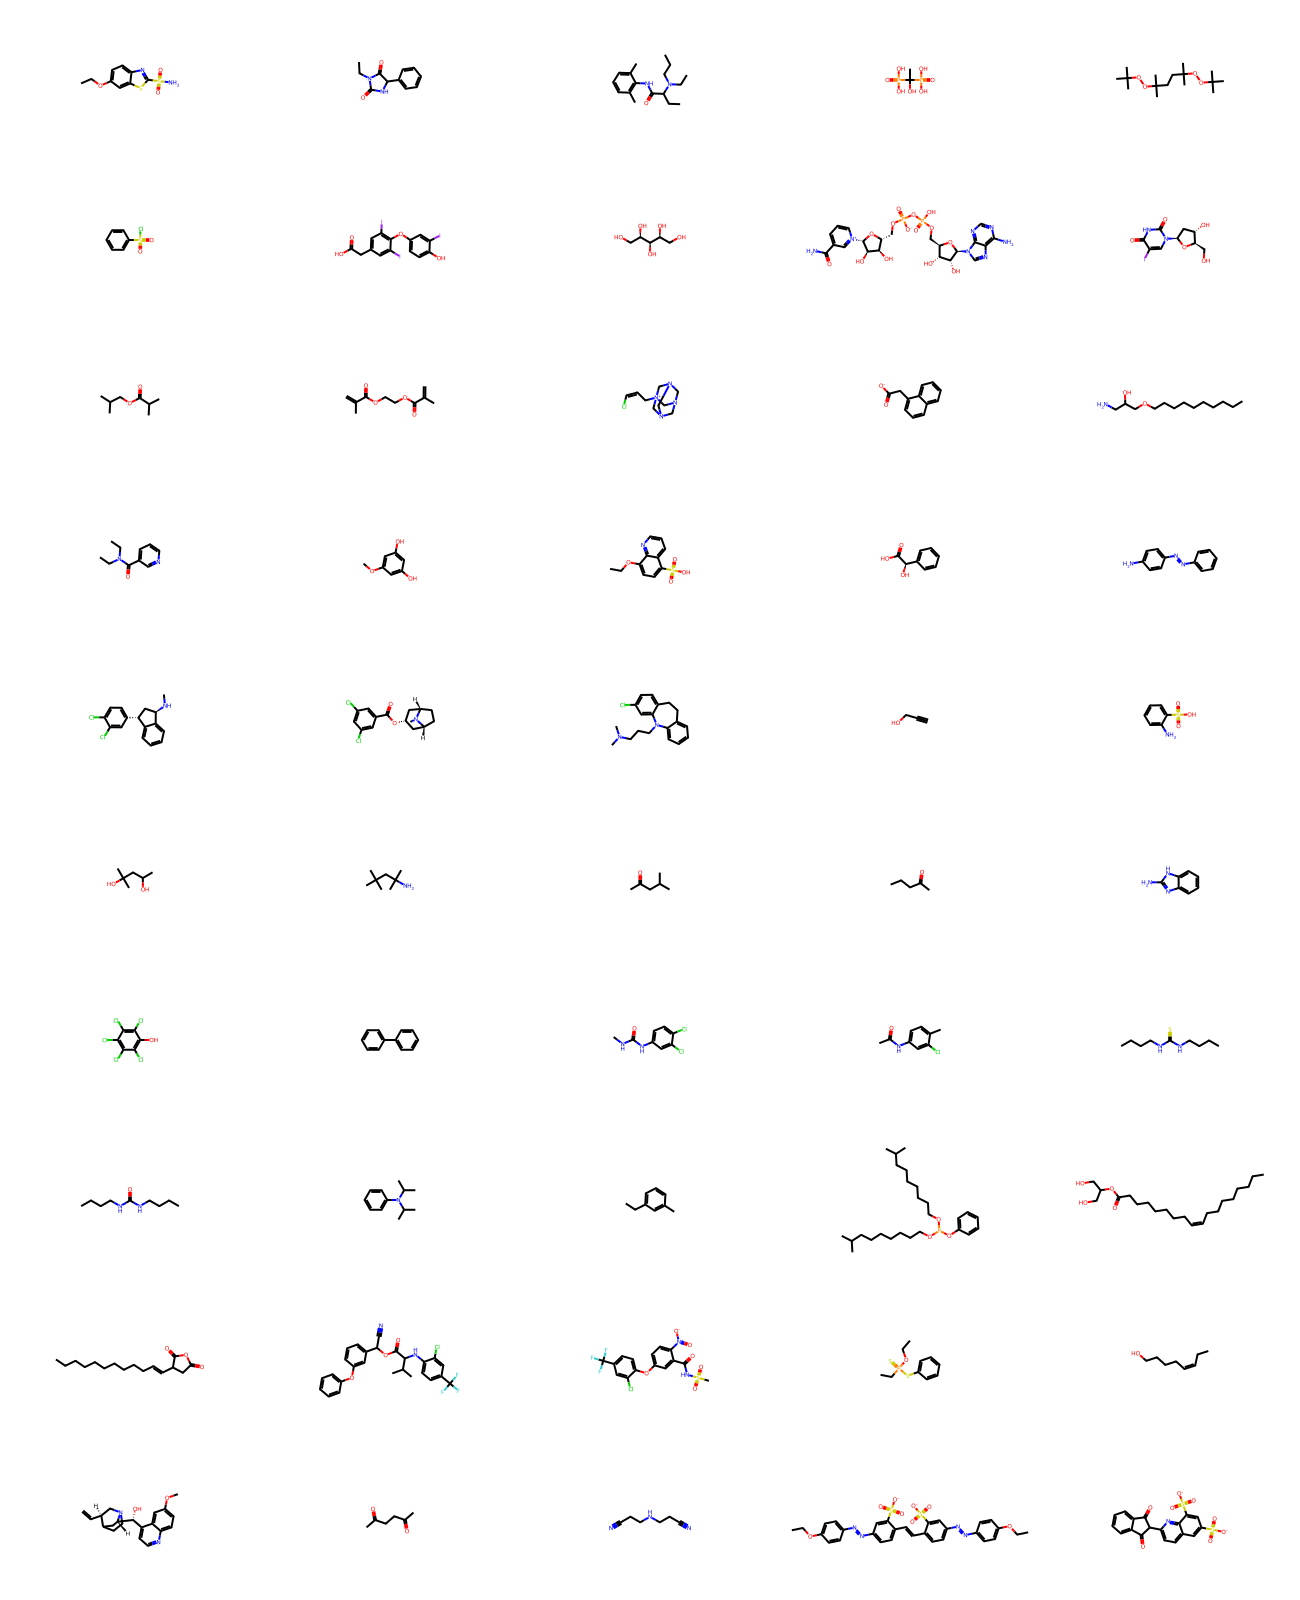

In [18]:
molecules = [Chem.MolFromSmiles(i) for i in df['smiles']]


MolsToGridImage(
    [m for m in molecules if m is not None][:1000], molsPerRow=5, subImgSize=(260, 160)
)

# bond, atom Dictionary  생성

In [19]:
# bond_mapping Dictionary 생성
bond_mapping = {"SINGLE": 1, "DOUBLE": 2, "TRIPLE": 3, "AROMATIC": 4}
bond_mapping.update({1:BondType.SINGLE, 2: BondType.DOUBLE, 3: BondType.TRIPLE, 4: BondType.AROMATIC})

# 새로운 DF의 'smiles' 컬럼에서 원자 종류 뽑는 과정
# atom_type = df['smiles'].apply(lambda x: [symbol for symbol in x if symbol.isalpha()]).explode().unique()
# SMILE_CHARSET = atom_type.tolist()
# SMILE_CHARSET.sort()
# print('SMILE_CHARSET: ', SMILE_CHARSET)

# atom_mapping_Dictionary 생성
SMILE_to_index = dict((c, i) for i, c in enumerate(SMILE_CHARSET))
index_to_SMILE = dict((i, c) for i, c in enumerate(SMILE_CHARSET))
atom_mapping = dict(SMILE_to_index)
atom_mapping.update(index_to_SMILE)
print('atom_mapping: ', atom_mapping)

atom_mapping:  {'C': 0, 'F': 1, 'H': 2, 'N': 3, 'O': 4, 'B': 5, 'Br': 6, 'Cl': 7, 'I': 8, 'P': 9, 'S': 10, 0: 'C', 1: 'F', 2: 'H', 3: 'N', 4: 'O', 5: 'B', 6: 'Br', 7: 'Cl', 8: 'I', 9: 'P', 10: 'S'}


# Train, Val, Test 분리

In [20]:
from sklearn.model_selection import train_test_split

shuffled_indices = df.sample(frac=1, random_state=100).index
shuffled_df = df.sample(frac=1, random_state=100)

train_ratio = 0.9
val_ratio = 0.07
test_ratio = 0.03

# train, val, test indices 분리
train_indices, val_test_indices = train_test_split(shuffled_indices, 
                                                   train_size=train_ratio, 
                                                   test_size=val_ratio+test_ratio, 
                                                   random_state=100)
val_indices, test_indices = train_test_split(val_test_indices, 
                                             train_size=val_ratio/(val_ratio+test_ratio), 
                                             test_size=test_ratio/(val_ratio+test_ratio), 
                                             random_state=100)

# train, val, test data 분리
train_data = df.loc[train_indices]
val_data = df.loc[val_indices]
test_data = df.loc[test_indices]

print("Train set size:", len(train_data))
print("Validation set size:", len(val_data))
print("Test set size:", len(test_data))

Train set size: 6815
Validation set size: 530
Test set size: 228


In [21]:
print("Train indices length:", len(train_indices))
print("Validation indices length:", len(val_indices))
print("Test indices length:", len(test_indices))

Train indices length: 6815
Validation indices length: 530
Test indices length: 228


# 각 데이터셋으로 Dict 생성

In [22]:
print('Generating train_list_of_dict...')
train_list_of_dict = generate_pickle(train_data)
print('train_list_of_dict generated')

print('Generating val_list_of_dict...')
val_list_of_dict = generate_pickle(val_data)
print('val_list_of_dict generated')

print('Generating test_list_of_dict...')
test_list_of_dict = generate_pickle(test_data)
print('test_list_of_dict generated')

Generating train_list_of_dict...


/tmp/ipykernel_7953/1605162562.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'atom_type' : torch.tensor(features, dtype=torch.int8),
/tmp/ipykernel_7953/1605162562.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'bond_type' : torch.tensor(adjacency, dtype=torch.int8),
[16:10:29] WARNING: not removing hydrogen atom without neighbors


train_list_of_dict generated
Generating val_list_of_dict...
val_list_of_dict generated
Generating test_list_of_dict...
test_list_of_dict generated


# index, pickle 저장

!!! 경로 수정 !!!

In [24]:
# Define the file paths for saving the data and indices
#file_path = "/home/sjang/MILESTONE/2_GeneratePickles/3_dipolemoment/"
file_path = "./data/molecules/"
# train_index_path = file_path + "train.index"
# val_index_path = file_path + "val.index"
# test_index_path = file_path + "test.index"
train_data_path = file_path + "train.pickle"
val_data_path = file_path + "val.pickle"
test_data_path = file_path + "test.pickle"

# Save the train, validation, and test indices as separate .INDEX files
# np.savetxt(train_index_path, train_indices, delimiter=',', fmt='%d')
# np.savetxt(val_index_path, val_indices, delimiter=',', fmt='%d')
# np.savetxt(test_index_path, test_indices, delimiter=',', fmt='%d')

# Save train data
with open(train_data_path, 'wb') as f:
    pickle.dump(train_list_of_dict, f)

# Save validation data
with open(val_data_path, 'wb') as f:
    pickle.dump(val_list_of_dict, f)

# Save test data
with open(test_data_path, 'wb') as f:
    pickle.dump(test_list_of_dict, f)

In [25]:
train_data.head(3)

,Unnamed: 0,smiles,Y
6857,6860,c1ccc2sc(SN(C3CCCCC3)C3CCCCC3)nc2c1,0.0
7237,7240,N#CSCSc1nc2ccccc2s1,1.0
6090,6093,CCCCCCCCN1C=CN(C)C1,0.0


In [104]:
train_indices[:3]

Index([6857, 7237, 6090], dtype='int64')

In [105]:
train_list_of_dict[:3]

[{'num_atom': 23,
  'atom_type': tensor([0, 0, 0, 0, 3, 0, 3, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0],
         dtype=torch.int8),
  'bond_type': tensor([[0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4],
          [4, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
          [0, 4, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
          [0, 0, 4, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0],
          [0, 0, 0, 4, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
          [0, 0, 0, 0, 4, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0],
          [0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 0, 0, 0, 0, 

## 7월 21일 금요일 업데이트 목록
* MolFromSmiles 로 변환 안되던 smiles 4개 제거
* canonicalize - 제가 까먹고 안했던거 같아서 했습니다!
* 파일생성까지 잘되는거 확인했습니다!

# 7월 22일 토요일 업데이트 목록
* tox 형식으로 변경후 적용
* 개인의 판단으로 일단 Nd, Dy, Se(se) 삭제
* 원래 하셧던 방식으로 atom_map을 sort 해서 정렬후 만들어야 할까요? 여러 데이터셋의 atom_map 의 순서가 다르면 pre-trained 모델에 거칠때 문제가 없을까요?